# Project Topic: Application of Ensemble Learning (Blending) in developing a Predictive model for Nvidia Stock price uptrend move.
### - Caleb Fowowe

#### Import Libraries

In [89]:
from sklearn.linear_model import LogisticRegression

from src.utils_data_processing import LoadData, cwts, getpath
from src.utils_features_engineering import (FeaturesCreation, FeaturesTransformation, FeaturesSelection)
from src.utils_model_and_tuning import Blending, HpTuning

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd

import numpy as np
import quantstats as qs
from datetime import datetime

# Creates a folder for saving of code graphics and trading strategy report.
output_path = getpath()

### Load Data, EDA, Fix Null Data, and Plot Candlestick

In [90]:
data_files = {'files': ['NVDA', 'VVIX_History', 'USCPI', 'USGDP', 'FedFundRate', '2yrTreasury', '10yrTreasury']} #File names of the data as dictionary values

time_period = ['2008', '2024'] #specifies a period range, in the case provided data is goes back than required.
company_name = data_files['files'][0] #Extract the stock or company name here

ldata = LoadData(*time_period, **data_files) #instantiate the class

df = ldata.joinData() #merge all data together to form a single dataframe.

##### Exploratory Data Analysis (EDA)

In [91]:
### Check and fix null data (null data)
print(ldata.checkNullData(df)) #check for missing data in the dataset
df = ldata.fixNullData(df, method='bfill') #Intiall step of fixing missing data, based on the earlier stated method, here backfill is method is used tp backfill quarterly, and monthly macrodata
print(ldata.checkNullData(df)) #check for null data after fixing null data
df = ldata.fixNullData(df, method='knnimpute') #fix future data that are not available yet, can drop rows to choose, knn_impute method was used here.
# ldata.plotCandleStick(df)
ldata.plotPrices(df)
df.tail()

                Open      High       Low     Close   Volume  MarketValue  \
Dates                                                                      
2011-09-16    1.6520    1.7227    1.6327    1.7200  21263.6      2683.67   
2011-09-19    1.6633    1.7207    1.5880    1.7180  17360.2      2680.55   
2011-09-20    1.7320    1.7733    1.7113    1.7340  17705.3      2705.52   
2011-09-21    1.7300    1.7967    1.7133    1.7233  14813.6      2688.87   
2011-09-22    1.7093    1.7407    1.6587    1.7087  11640.0      2665.99   
...              ...       ...       ...       ...      ...          ...   
2024-08-09  197.0500  200.8800  195.1100  200.0000  58648.3    637839.30   
2024-08-12  199.0200  199.2600  194.6700  197.4900  64044.9    629834.40   
2024-08-13  198.4700  208.4900  197.0600  207.8300  76247.4    662810.70   
2024-08-14  207.3900  208.4400  198.7500  201.3800  70250.0    642240.40   
2024-08-15  205.0200  215.8800  204.8200  214.1400  89848.5    682934.60   

           

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
Dates,,,,,,,,,,,,,,,,
2024-08-09,197.05,200.88,195.11,200.00,58648.3,637839.3,0.0,56.2,3.56,10.17,114.63,0.05294,0.032975,0.0025,0.03940,0.03850
2024-08-12,199.02,199.26,194.67,197.49,64044.9,629834.4,0.0,55.5,3.56,10.04,121.94,0.03766,0.040753,0.0025,0.03940,0.03850
2024-08-13,198.47,208.49,197.06,207.83,76247.4,662810.7,0.0,58.4,3.56,10.57,113.89,0.04478,0.032975,0.0025,0.03940,0.03850
2024-08-14,207.39,208.44,198.75,201.38,70250.0,642240.4,0.0,56.6,3.56,10.24,107.81,0.04976,0.032975,0.0025,0.03964,0.03833
2024-08-15,205.02,215.88,204.82,214.14,89848.5,682934.6,0.0,60.1,3.56,10.89,105.42,0.06054,0.023978,0.0070,0.04097,0.03915


In [92]:
df.describe()

,Open,High,Low,Close,Volume,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,10yrTreasury
count,1057.000000,1057.000000,1057.000000,1057.000000,1057.000000,1.057000e+03,1057.0,1057.000000,1057.000000,1057.000000,1057.000000,1057.000000,1057.000000,1057.000000,1057.000000,1057.000000
mean,220.850293,225.756470,215.613039,220.787002,106492.178903,6.766587e+05,0.0,328.091296,2.107228,17.359177,101.277323,0.047509,0.047156,0.025853,0.025950,0.027915
std,71.949460,73.467086,70.125866,71.746545,55740.914405,2.222145e+05,0.0,405.865651,1.486738,7.425640,16.848498,0.023636,0.077846,0.023532,0.020034,0.013074
min,1.552700,1.621300,1.528700,1.577300,7657.200000,2.461070e+03,0.0,4.800000,0.140000,5.500000,73.260000,0.009900,-0.019759,0.002500,0.001090,0.004980
25%,182.400000,185.860000,177.650000,182.450000,70806.300000,5.699495e+05,0.0,56.200000,0.330000,11.180000,86.340000,0.031400,0.022442,0.002500,0.002260,0.015470
50%,224.000000,229.330000,218.150000,223.333300,96870.800000,6.781784e+05,0.0,95.900000,2.460000,16.100000,100.540000,0.041600,0.032975,0.017500,0.030950,0.029930
75%,260.299800,266.333300,256.263200,260.540000,127524.100000,8.090353e+05,0.0,412.000000,3.400000,22.420000,113.850000,0.068100,0.042056,0.055000,0.045410,0.039980
max,411.469700,414.496600,405.666300,409.969700,666378.400000,1.235155e+06,0.0,1714.700000,4.300000,42.080000,173.320000,0.090600,0.348397,0.055000,0.052200,0.049830


## Feature Engineering

##### FeaturesEngineering Class with the entire FeaturesCreation, FeaturesTransformation, and FeaturesSelections sub-classes

#### Feature Creation/Extraction

##### Define the parameters to be used in the target variable (y)/ Label

In [93]:
# The target is a trend and volatility play which creates a signal when the return over a short period of time (5days), crosses over the return trend over a relative medium period (10days). However, there is an outperformance threshold (hurdle) over which the 5-day return must outperform the medium_period return before it is charactersized as a condtion. The other condition is a volatility play where the standard deviation of the short period return is less than the upper boundary standard deviation of the medium period return. The upper boundary of the medium period returns standard deviation is characterized as 2-standard deviations from the mean

# Target parameters
short_prd= 5 
medium_prd = 10
upper_std=2 
lower_std = 1 
hurdle = 0.005

##### Generate Features - all features (pandas-ta library)

In [94]:
# Instantiate the features creation subclass with the dataframe containing the cleaned data, and the testsize as input parameters. The testsize is opional and has a default value of 20%.
# The testsize is provided during the Features engineering process because it will be used during features selection step.

feat_df = FeaturesCreation(df, short_prd, medium_prd, upper_std, lower_std, hurdle) #Instantiate the FeaturesCreation subclass providing the dataframe and the target parametres as inputs
new_ft = feat_df.create_all_features(fundamental_features=True, macro_features=True) # If the Fundamental and Macro ratios are provided, genrates a feature set of:
#1. Company fundamentals-related Features (Requires specific column label)
#2. Macro-economic related features (Requires specific column label)
#3. Technical Indicator features (based on pandas ta-library) (Requires specific column label 'Open', 'High', 'Low', 'Close', 'Volume')

# The ohlcv columns are dropped after using them in the generation of the technical indicators. Below is a preview of the first five row of the 320features including both, macroeconomic, fundamental and technical indicators.
new_ft.head()

Price-to-Earnings-to-Dividend Ratio (PED)Ratio feature successfully calculated
Price to Earnings and Price to Book Combined (PEPB)_Ratio feature successfully calculated
combined valuation metric (cvm)_feature successfully calculated


,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,...,VWMA_10,TSV_18_10,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,predict
Dates,,,,,,,,,,,,,,,,,,,,,
2020-10-26,398383.8,0.0,1015.2,0.14,18.15,133.08,0.0118,0.042056,0.0025,0.00149,...,145.075372,-951491.91844,-501764.538609,1.896292,558.7733,-77.956692,142.506798,140.234809,-0.44572,0
2020-10-27,402554.4,0.0,1025.8,0.14,18.34,135.32,0.0118,0.042056,0.0025,0.00149,...,144.457447,-1823362.42398,-589681.124761,3.092116,566.6534,-70.437698,141.950382,140.599407,-0.153298,0
2020-10-28,384866.6,0.0,788.4,0.17,17.54,152.01,0.0118,0.042056,0.0025,0.0015,...,142.326921,63874.8777,-397507.936619,-0.160688,545.5467,-99.966444,140.396207,138.44497,-1.156048,0
2020-10-29,389426.1,0.0,797.7,0.17,17.75,147.84,0.0118,0.042056,0.0025,0.00152,...,141.076682,-300756.077,-118231.610077,2.543787,548.7265,-91.936574,139.468573,137.578011,-0.844712,0
2020-10-30,367823.4,0.0,753.5,0.17,16.76,145.24,0.0118,0.042056,0.0025,0.00152,...,138.925018,-696308.40314,-48547.560267,14.342809,520.9272,-89.710681,137.390344,134.127482,-1.927098,0


In [95]:
new_ft.shape

(957, 336)

#### Feature Transformation & Selection

##### Transform day feature column

In [96]:
# Prior to starting to features selection process, the days features which consist of trading days (Monday - Friday), is transformed, to two features.
feat_transform = FeaturesTransformation(new_ft) #Instantiate the FeaturesTransformation subclass providing the dataset with the generated features as input
new_ft2 = feat_transform.transformDaysColumn() # Invoke the transformDaysColumn method which has the defined DaysTransformer subclass to transform the 'days' column. The column named 'days' must be in the input dataset for this method to execute. The whole feature set with the transformed 'days' column is stored in the 'new_ft2' variable.

###### To optimize the dataframe performance, the all features outside the target column are convereted to 'float64', with the target variable column converted to 'int16' datatype

In [97]:
new_ft2 = new_ft2.astype('float64')
new_ft2['predict'] = new_ft2['predict'].values.astype('int16')

In [98]:
new_ft2

,MarketValue,DividendYield,PriceToEarnings,EPS,PriceToBook,VVIX,CPI,GDP,FedFundRate,2yrTreasury,...,TSVs_18_10,TSVr_18_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,predict,dsin,dcos
Dates,,,,,,,,,,,,,,,,,,,,,
2020-10-26,398383.8,0.0,1015.2,0.14,18.15,133.08,0.01180,0.042056,0.0025,0.00149,...,-5.017645e+05,1.896292,558.7733,-77.956692,142.506798,140.234809,-0.445720,0,0.781831,0.623490
2020-10-27,402554.4,0.0,1025.8,0.14,18.34,135.32,0.01180,0.042056,0.0025,0.00149,...,-5.896811e+05,3.092116,566.6534,-70.437698,141.950382,140.599407,-0.153298,0,0.974928,-0.222521
2020-10-28,384866.6,0.0,788.4,0.17,17.54,152.01,0.01180,0.042056,0.0025,0.00150,...,-3.975079e+05,-0.160688,545.5467,-99.966444,140.396207,138.444970,-1.156048,0,0.433884,-0.900969
2020-10-29,389426.1,0.0,797.7,0.17,17.75,147.84,0.01180,0.042056,0.0025,0.00152,...,-1.182316e+05,2.543787,548.7265,-91.936574,139.468573,137.578011,-0.844712,0,-0.433884,-0.900969
2020-10-30,367823.4,0.0,753.5,0.17,16.76,145.24,0.01180,0.042056,0.0025,0.00152,...,-4.854756e+04,14.342809,520.9272,-89.710681,137.390344,134.127482,-1.927098,0,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,637839.3,0.0,56.2,3.56,10.17,114.63,0.05294,0.032975,0.0025,0.03940,...,-6.427178e+06,1.150097,795.9900,-75.596331,203.649818,195.672327,-1.358386,0,-0.974928,-0.222521
2024-08-12,629834.4,0.0,55.5,3.56,10.04,121.94,0.03766,0.040753,0.0025,0.03940,...,-6.921112e+06,0.956639,788.9100,-70.596052,201.349091,195.430086,-1.469376,0,0.781831,0.623490
2024-08-13,662810.7,0.0,58.4,3.56,10.57,113.89,0.04478,0.032975,0.0025,0.03940,...,-6.996962e+06,0.845158,821.2100,-50.968109,201.557636,200.606434,-0.998756,0,0.974928,-0.222521


#### Feature Selection

###### Feature selection - Wrapper Method: Boruta and Recursive Forward Elimination (RFE)

In [99]:
feat_select = FeaturesSelection(new_ft2, testsize = 0.20) #instantiate the FeaturesSelection subclass, providing dataframe from above, with the days column transformed as required input parameters, and the testsize as an optional input parameter as well. Default testsize is 0.20.
feat1 = feat_select.wrapper_boruta(max_iter=200) # Invoke the wrapper_boruta method within the FeaturesSelection subclass.

#The wrapper_boruta method

Pre-Boruta selection metrics: Accuracy Score:  91.15%, f1_score: 91.14% 


Using the (72)BorutaSelected Features, metrics: Accuracy Score: 91.67%, f1_score: 91.62% 


 Using Recursive Forward Elimination (RFE) approach to validate the (72)features selected by Boruta approach,(49)features which are the intersect features for both Boruta and RFE, the evaluation metrics using the (49)features are: Accuracy Score:  91.15%, f1_score: 91.03% 



##### Feature selection - Filtering Method: Addressing Multicollinearity among features

###### using the same Feature Selection class, specify the correlation coefficient Threshold of choice. (The projected tested correlation in the 0.60 - 0.90) ranges.

In [100]:
# Call the filter_correlation method, within the class providing it with the desired correlation threshold.
# The multicollinearity steps follows the Boruta and RFE intersection steps. Hence, there is no need to specify the dataframe, the code has designed such that it already takes as input the dataframe which contains the features output of Boruta and RFE intersection. 
# However, for testing purposes, there's an optionality to provide the function with both correlation coefficient and dataframe, and it will filter for multicollinearitu among features.
filtered_feature = feat_select.filter_correlation(corr_coeff=0.70)  


 Solving for multicollinearity of features, and applying correlation coefficient of 0.7, the (49)features selected which are the intersected features of Boruta and Recursive ForwardElimination (RFE) were filtered to 7 features 


 After addressing the multicollinearity among features, applying RandomForestClassifier to predictthe (7)Filtered Features gives the following values for tracked metrics: Accuracy Score: 80.21%, f1_score: 80.27% 

╒═════╤═══════════════════════════╕
│   # │ Filtered Features Names   │
╞═════╪═══════════════════════════╡
│   0 │ TMO_14_5_3                │
│   1 │ CFO_9                     │
│   2 │ CHOP_14_1_100.0           │
│   3 │ SKEW_30                   │
│   4 │ EXHC_DNa                  │
│   5 │ BBP_5_2.0                 │
│   6 │ PVOh_12_26_9              │
╘═════╧═══════════════════════════╛


In [101]:
data3 = new_ft2[filtered_feature]
data3['predict'] = new_ft2['predict'].values.astype('int')

data3.head()

,TMO_14_5_3,CFO_9,CHOP_14_1_100.0,SKEW_30,EXHC_DNa,BBP_5_2.0,PVOh_12_26_9,predict
Dates,,,,,,,,
2020-10-26,-5.727148,2.753352,50.161214,-0.687203,7.0,0.248481,-1.528401,0
2020-10-27,-6.525794,2.496541,49.173940,-0.662500,0.0,0.716068,-2.638057,0
2020-10-28,-8.037711,-1.081355,49.161334,-0.508176,1.0,0.024110,-2.707275,0
2020-10-29,-9.535398,0.289984,49.739393,-0.436918,2.0,0.295934,-3.051190,0
2020-10-30,-10.778727,-2.680129,38.474047,-0.389474,3.0,0.071876,0.653818,0


### Ensemble Model - Blending Ensemble

##### Initial parameterization of basemodels and metamodel

In [102]:
cls_weight = cwts(data3)

lr_params = {'random_state': 1, 'class_weight': cls_weight}
lr = LogisticRegression(**lr_params)

dt_params = {'class_weight': cls_weight, 'random_state': 1}
dt = DecisionTreeClassifier(**dt_params)

knn_params = {'algorithm': 'auto', 'n_jobs': -1}
knn = KNeighborsClassifier(**knn_params)

bayes_params = {}
bayes = GaussianNB()
bayes.set_params(**bayes_params)

svc_params = {'class_weight': cls_weight,'random_state': 1, 'probability': True}
svc = SVC(**svc_params)

basemodels = {'lr': lr, 'dte': dt, 'knn': knn, 'bayes': bayes, 'svc': svc}

xgb_params = {'n_jobs': -1, 'class_weight': cls_weight, 'random_state': 1, 'verbose': 1}
xgb = XGBClassifier(**xgb_params)

blender = xgb

##### Initial run of the blending model

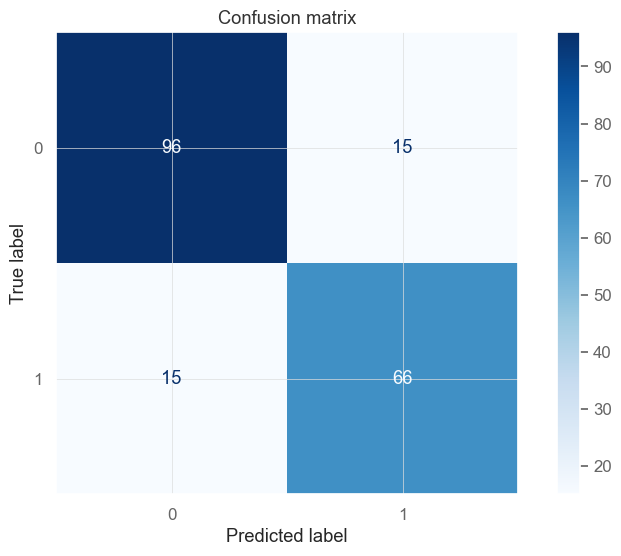

AUC-ROC curve 



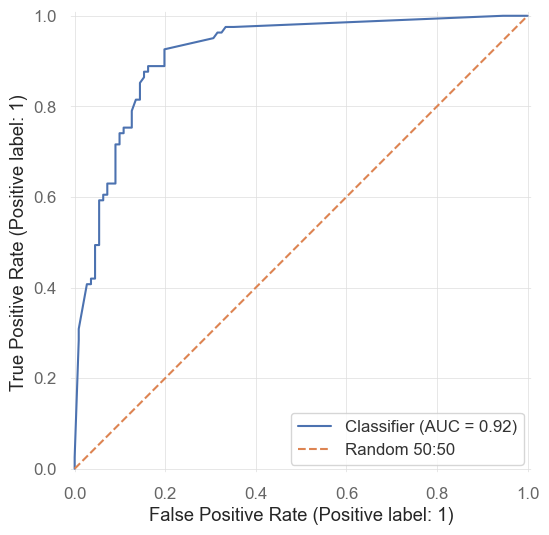

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       111
           1       0.81      0.81      0.81        81

    accuracy                           0.84       192
   macro avg       0.84      0.84      0.84       192
weighted avg       0.84      0.84      0.84       192

Accuracy Score:  84.4%, f1score: 84.4%


In [103]:
#Separate final X and y - Features and target
X_final = data3.iloc[:,:-1].values
y_final = data3.iloc[:,-1].values

Blnd = Blending(X_final, y_final, basemodels, blender, valsize=0.20)
acc, f1score, ypred, yprob, yfull = Blnd.runBlendingEnsemble()

print(f"Accuracy Score: {acc: .1%}, f1score: {f1score:.1%}")

#### Hyperparamter Tuning

In [104]:
#Instantiate tuning
tune_model = HpTuning(X_final, y_final, n_trials=40)
tuned_lr, tuned_dt, tuned_svc, tuned_knn, tuned_bayes, tuned_xgb = tune_model.optimize_lr(), tune_model.optimize_dt(), tune_model.optimize_svc(), tune_model.optimize_knn(), tune_model.optimize_bayes(), tune_model.optimize_xgb()

print("optimal_lr:", tuned_lr.values, "\t","optimal_dt:", tuned_dt.values, "\t", "optimal_svc:", tuned_svc.values, "\t", "optimal_knn:", tuned_knn.values, "\t", "optimal_bayes:", tuned_bayes.values, "\t", "optimal_xgb:", tuned_xgb.values)

optimal_lr: [0.8861584205545342, 0.8861256544502618] 	 optimal_dt: [0.8677414210224502, 0.8678010471204188] 	 optimal_svc: [0.8965681726948928, 0.8965968586387435] 	 optimal_knn: [0.883283204099488, 0.8835078534031413] 	 optimal_bayes: [0.8680295383873599, 0.8678010471204188] 	 optimal_xgb: [0.8899310968495812, 0.8900523560209423]


#### Run Ensemble Model with tuned parameters

##### Update the initial parameters dictionary with the hyperparameter tuning parameter values

In [105]:
lr_params.update(tuned_lr.params)
lr = LogisticRegression(**lr_params)

dt_params.update(tuned_dt.params)
dt = DecisionTreeClassifier(**dt_params)

knn_params.update(tuned_knn.params)
knn = KNeighborsClassifier(**knn_params)

bayes_params = {}
bayes = GaussianNB()
bayes.set_params(**bayes_params)

svc_params.update(tuned_svc.params)
svc = SVC(**svc_params)

basemod_upd = {'lre': lr, 'dte': dt, 'knn': knn, 'bayes': bayes, 'svc': svc}

xgb_params.update(tuned_xgb.params)
xgb = XGBClassifier(**xgb_params)

blender_upd = xgb

##### TunedModels Output

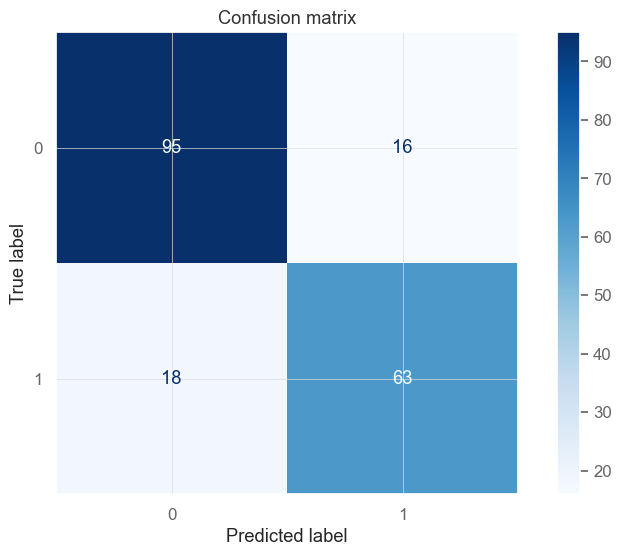

AUC-ROC curve 



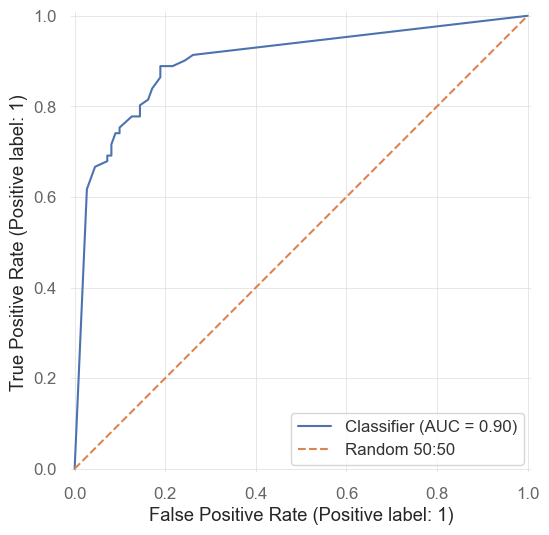

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       111
           1       0.80      0.78      0.79        81

    accuracy                           0.82       192
   macro avg       0.82      0.82      0.82       192
weighted avg       0.82      0.82      0.82       192

Accuracy Score:  82.3%, f1score: 82.3%


In [106]:
Blnd = Blending(X_final, y_final, basemod_upd, blender_upd, valsize=0.20)
acc_tuned, f1score_tuned, ypred_tuned, yprob_tuned, yfull_tuned = Blnd.runBlendingEnsemble()

print(f"Accuracy Score: {acc_tuned: .1%}, f1score: {f1score_tuned:.1%}")

### Backtest/Strategy Evaluation

##### Trading Strategy - full period backtest

In [107]:
return_period = 1

In [108]:
# Extract Close prices over the range of dates of the full model
backtest_data = df[['Close', 'Open']][-len(yfull_tuned):]
backtest_data['Signal'] = yfull_tuned

backtest_data

,Close,Open,Signal
Dates,,,
2020-10-26,140.0933,137.2099,0
2020-10-27,141.5600,141.2533,0
2020-10-28,135.3400,138.8266,0
2020-10-29,136.9433,136.6533,0
2020-10-30,129.3467,135.6318,0
...,...,...,...
2024-08-09,200.0000,197.0500,0
2024-08-12,197.4900,199.0200,0
2024-08-13,207.8300,198.4700,0


In [109]:
#Entry logic
backtest_data['Entry'] = np.where(backtest_data['Signal']==1, backtest_data['Close'], 0) #when the strategy signal is 1, we enter into a trade, and buy at the end of day's close.

#Exit Logic
backtest_data['Exit'] = np.where((backtest_data['Entry'] != 0) & (backtest_data['Open'].shift(-return_period) <= backtest_data['Close']),
                         backtest_data['Open'].shift(-return_period), 0) #
backtest_data['Exit'] = np.where((backtest_data['Entry'] != 0) & (backtest_data['Open'].shift(-return_period) > backtest_data['Close']),
                         backtest_data['Close'].shift(-return_period), backtest_data['Exit'])

# Calculate MTM
backtest_data['P&L'] = backtest_data['Exit'] - backtest_data['Entry']

# Generate Equity Curve
backtest_data['Equity'] = backtest_data['P&L'].cumsum() + backtest_data['Close'][0]

# Calculate Benchmark Return
backtest_data['Benchmark'] = np.log(backtest_data['Close']).diff().fillna(0)

# Calculate Strategy Return
backtest_data['Strategy'] = (backtest_data['Equity']/backtest_data['Equity'].shift(return_period) - 1).fillna(0)
backtest_data = backtest_data.iloc[:-1]

##### Calculate the Sharpe Ratio

In [110]:
bts = backtest_data[['Benchmark','Strategy']]
qs.stats.sharpe(bts)

Benchmark    0.162442
Strategy     0.913960
dtype: float64

In [111]:
# generate report and save in the output folder
date_time = datetime.now().strftime('%Y-%m-%d, %H%M%S')
qs.reports.html(bts['Strategy'], bts['Benchmark'],  title=f'Strategy BackTest Report for {company_name}',
                output=f'{output_path}/{company_name}_backtest_report_full_period-{date_time}.html')

In [112]:
# qs.reports.full(bts['Strategy'], benchmark=bts['Benchmark'], mode='full', title=f'Strategy BackTest Report for {company_name}')

#### Out of Sample Test
##### Trading Strategy - For Test Data Period alone

In [113]:
btdata = df['Close'][-len(ypred):]
btdata = btdata.to_frame()
btdata['Benchmark'] = np.log(btdata['Close']).diff().fillna(0)
btdata['Signal'] = ypred
btdata['Strategy'] = btdata.Benchmark * btdata.Signal.shift(1).fillna(0)

In [114]:
# generate report and save in the output folder
qs.reports.html(btdata['Strategy'], btdata['Benchmark'], title=f'Strategy BackTest Report for {company_name}', 
                output=f'{output_path}/{company_name}_backtesting_report_test_period-{date_time}.html')

In [115]:
bto = btdata[['Benchmark','Strategy']]
qs.stats.sharpe(bto)

Benchmark    0.046615
Strategy    -0.644095
dtype: float64